# Creating Raster Information Product using Raster Analytics

## Raster Analytics

ArcGIS Enterprise at 10.5 provides you with the ability to perform large raster analysis using distributed computing. This capability is provided in the `arcgis.raster.analytics` module and includes functionality to summarize data, analyze patterns, images, terrain and manage data. This sample show the capabilities of imagery layers and raster analytics.

## Imagery layers

In [1]:
import arcgis
from arcgis.gis import GIS
from IPython.display import display

gis = GIS()

Here we're searchcing for multispectral landsat imagery layer:

In [2]:
items = gis.content.search("Landsat 8 Views", "Imagery Layer", max_items=2)

In [3]:
for item in items:
    display(item)

<Item title:"Landsat 8 Views" type:Imagery Layer owner:esri>

<Item title:"MDA NaturalVue Satellite Imagery" type:Imagery Layer owner:esri>

In [4]:
landast_item = items[0]

In [5]:
imglyr = landast_item.layers[0]

This layer has been published with several Raster Functions, that the code below is cycling through, and listing out:

In [6]:
for fn in imglyr.properties['rasterFunctionInfos']:
    print (fn['name'])

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA
Agriculture
Bathymetric
Color Infrared
Geology
Natural Color
Short-wave Infrared
NDVI Colorized
Normalized Difference Moisture Index Colorized
NDVI Raw
NBR Raw
None


Let us create a map widget and load this layer

In [7]:
marthasbasin = arcgis.geocoding.geocode("Marthas Basin, Montana")[0]

In [8]:
map1 = gis.map(marthasbasin, zoomlevel=12)

In [9]:
map1

In [10]:
map1.add_layer(imglyr)

The utility of raster functions is better seen when we interactively cycle through these raster functions and apply them to the map, like the code below does. This is using on-the-fly image processing at display resolution to cycle through the various raster functions, and showing how the layer can be visualized using these different raster functions published with the layer.

In [11]:
import time
from arcgis.raster.functions import apply

for fn in imglyr.properties['rasterFunctionInfos'][:6]:
    print(fn['name'])
    map1.remove_layers()
    map1.add_layer(apply(imglyr, fn['name']))
    time.sleep(2)
    

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA


## Raster functions

Developers can create their own **raster functions**, by chaining different raster functions. For instance, the code below is doing an Extract Band and extracting out the [4,5,3] band combination, and applying a Stretch to get the land-water boundary visualization that makes it easy to see where land is and where water is. Its worth noting that the raster function is applied at display resolution and only for the visible extent using on the fly image processing.

In [12]:
from arcgis.raster.functions import stretch, extract_band

def process_bands(layer, bands):
    return stretch(extract_band(layer, bands), 
                    stretch_type='percentclip', min_percent=0.1, max_percent=0.1, gamma=[1, 1, 1], dra=True)

Let us apply this raster function to the image layer to visualize the results.

In [13]:
map2 = gis.map(marthasbasin, zoomlevel=12)
map2

In [14]:
map2.add_layer(process_bands(imglyr, [4, 5, 3]))

# Creating a Raster Information Product using Landsat 8 imagery

This part of the notebook shows how **Raster Analytics** (in ArcGIS Enterprise 10.5) can be used to generate a raster information product, by applying the same raster function across the extent of an image service on the portal. The raster function is applied at source resolution and creates an Information Product, that can be used for further analysis and visualization.

In [15]:
portal = GIS("https://dev003246.esri.com/portal", "admin")

Enter password: ········


<Item title:"ImgSrv_Landast_Montana2015" type:Imagery Layer owner:admin>
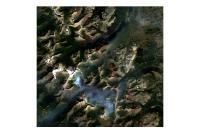

In [16]:
montana_landsat = portal.content.search("ImgSrv_Landast_Montana2015")[0]
montana_landsat

In the code below, we use extract and stretch the [7, 5, 2] band combination. This improves visibility of fire and burn scars by pushing further into the SWIR range of the electromagnetic spectrum, as there is less susceptibility to smoke and haze generated by a burning fire.

In [17]:
montana_lyr = montana_landsat.layers[0]

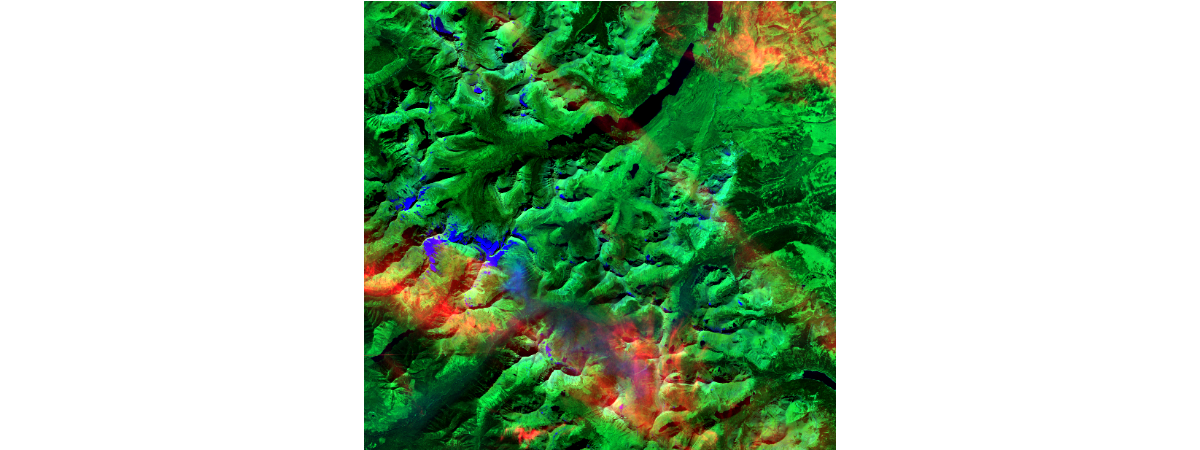

In [18]:
fire_viz = process_bands(montana_lyr, [7, 5, 2])
fire_viz

We can use the `save` method to apply the raster function across the entire extext of the input image layer at source resolution, and presist the result in an output image layer. This creates a raster product similar that can be used for further analysis and visualization.

In [19]:
arcgis.env.verbose = True

In [20]:
montana_fires_lyr = fire_viz.save('Montana_Burn_scars')

Submitted.
Executing...
Executing (GenerateRaster): GenerateRaster {"variableName":"Raster","rasterFunction":"Stretch","rasterFunctionArguments":{"Raster":{"variableName":"Raster","rasterFunction":"ExtractBand","rasterFunctionArguments":{"Raster":"https://dev003248.esri.com/rax/rest/services/ImgSrv_Landast_Montana2015/ImageServer","BandIDs":[7,5,2]}},"DRA":true,"Gamma":[1,1,1],"MinPercent":0.1,"MaxPercent":0.1,"UseGamma":true,"StretchType":6}} {"serviceProperties":{"serviceUrl":"http://dev003248.esri.com/rax/rest/services/Hosted/Montana_Burn_scars/ImageServer","name":"Montana_Burn_scars"},"itemProperties":{"itemId":"a44c78f1597c4075bc59ffc4b6eab4d3"}} # # #
Start Time: Wed Jul 26 23:18:10 2017
Running script GenerateRaster...
Image service Montana_Burn_scars already existed.
GetPrivateUrl returns: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/Montana_Burn_scars/ImageServer
The service got from item ID is: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/Montana

In [21]:
montana_fires_lyr

<Item title:"Montana_Burn_scars" type:Imagery Layer owner:admin>

In [23]:
base_map = portal.map(marthasbasin, 12)

natural_color_map = portal.map(marthasbasin, 12)
natural_color_map.add_layer(montana_landsat)

false_color_map = portal.map(marthasbasin, 12)
false_color_map.add_layer(montana_fires_lyr)

We can compare the natural color and false color images uaing a tabbed widget. 

In the false color image the red and brownish pixels correspond to burn scars of the fire:

In [24]:
import ipywidgets as widgets

tab = widgets.Tab([base_map, natural_color_map, false_color_map])
tab.set_title(0, 'Basemap')
tab.set_title(1, 'Natural Color')
tab.set_title(2, 'False Color')
tab

Thus using the same raster function, we were able to both visualize on the fly (in the case of Pallikaranai marsh example) and also derive a persisted image service (in the case of Montana example) using distributed raster analysis.